# Cinema Analytics and Prediction System - Revenue prediction

## 1. Pre-processing

In [1]:
# Import necessary libraries
import json
import ast
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, classification_report
from xgboost import XGBRegressor, XGBClassifier
from catboost import CatBoostRegressor, Pool
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score

In [2]:
# define near zero value
value_nearzero = 0.01
# Model saving flag
save = False

### Helper functions

In [3]:
#  Signed log transformation
def get_signed_log(x):
    if pd.isna(x):
        return np.nan
    elif x >= 0:
        return np.log1p(x)
    else:
        return -np.log1p(abs(x))

In [4]:
def get_first_label(x):
    if isinstance(x, str) and len(x.strip()) > 0:
        try:
            labels = ast.literal_eval(x)
            if isinstance(labels, list) and len(labels) > 0:
                return labels[0]
        except (ValueError, SyntaxError):
            return "Unknown"
    elif isinstance(x, list) and len(x) > 0:
        return x[0]
    return "Unknown"

In [5]:
def get_main_genre(x):
    if isinstance(x, str) and len(x.strip()) > 0:
        try:
            genres = ast.literal_eval(x)
            if isinstance(genres, list) and len(genres) > 0:
                return genres[0]
        except (ValueError, SyntaxError):
            return "Unknown"
    elif isinstance(x, list) and len(x) > 0:
        return x[0]
    return "Unknown"

In [6]:
def inverse_log(x):
    if pd.isna(x):
        return np.nan
    elif x >= 0:
        return np.expm1(x)
    else:
        return -np.expm1(abs(x))

In [7]:
def get_movie_season(month):
    if month in [4, 5, 6, 7]:
        return "Summer_Season"
    elif month in [11, 12]:
        return "Holiday_Season"
    elif month in [8, 9, 10]:
        return "Off_Season"
    else:
        return "Regular"

In [76]:
def get_hit_flop(row):
    if row['revenue_corrected'] > 2*row['budget_corrected']:
        return 1    
    else:
        return 0

In [8]:
def plot_budget_category(category, ymax):
    plt.figure(figsize=(8,4))
    plt.ylim(0,ymax)
    plt.hist(movies[movies['budget_category'] == category]['budget_corrected'], bins=100, edgecolor='k')
    plt.xlabel("Budget (Millions USD)")
    plt.title(f"Bin:{category}: Distribution of Movies")
    plt.show()

### Data Loading/merging

In [9]:
# Load CSV files combined (movies + credits) from eda.ipynb

movies_df = pd.read_csv('../data/merged_data.csv')
print(movies_df.shape)

#Load CSV file from tmdb details recived by API call
movies_tmdb_df = pd.read_csv('../data/budget_revenue_tmdb.csv')
print(movies_tmdb_df.shape)

(4803, 28)
(3618, 4)


In [10]:
print(len(movies_df[movies_df['budget'] < value_nearzero]))

1037


In [11]:
print(len(movies_tmdb_df[movies_tmdb_df['budget_tmdb'] < value_nearzero]))

0


In [12]:
movies_tmdb_df.isna().sum()

movie_id        0
movie_title     0
budget_tmdb     0
revenue_tmdb    0
dtype: int64

In [13]:
# Print colums with nan
nan_df = movies_df.isna().sum()
nan_nonzero = nan_df[nan_df > 0]
print("Features with NaN:", nan_nonzero.index.tolist())

Features with NaN: ['homepage', 'overview', 'release_date', 'runtime', 'tagline', 'release_year', 'release_month']


In [14]:
movies_full_df = movies_df.merge(movies_tmdb_df[['movie_id', 'budget_tmdb', 'revenue_tmdb']],
                                 on='movie_id', how='outer')

### Data cleaning/transformation

In [15]:
def choose_budget(row):
    budget_tmdb = row['budget_tmdb']
    budget = row['budget']    

    if budget_tmdb != 0 and (not pd.isna(budget_tmdb)):
        if (budget < value_nearzero):
            return budget_tmdb             
        elif (budget_tmdb > 2*budget):
            return budget_tmdb        
    return budget

In [16]:
def choose_revenue(row):
    revenue_tmdb = row['revenue_tmdb']
    revenue = row['revenue']   

    if revenue_tmdb != 0 and (not pd.isna(revenue_tmdb)):
        if (revenue < value_nearzero):
            return revenue_tmdb            
        elif (revenue_tmdb > 2*revenue):
            return revenue_tmdb       
    return revenue

In [17]:
movies_full_df['budget'] = movies_full_df.apply(choose_budget, axis=1)
movies_full_df['revenue'] = movies_full_df.apply(choose_revenue, axis=1)

In [18]:
print(movies_full_df.shape)
print(len(movies_full_df[movies_full_df['budget'] < value_nearzero]))
print(len(movies_full_df[movies_full_df['revenue'] < value_nearzero]))
print(len(movies_full_df[movies_full_df['budget'] == 0]))
print(len(movies_full_df[movies_full_df['revenue'] == 0]))

(4803, 30)
662
859
662
859


In [19]:
# Convert string to list for genre_labels
movies_full_df["genre_labels"] = movies_full_df["genre_labels"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

In [20]:
# load CPI dataset to correct budget/revenue for inflation
cpi = pd.read_csv("../data/flat-ui__data-Wed Jul 02 2025.csv")
cpi['Date'] = pd.to_datetime(cpi['Date'])

In [21]:
cpi = cpi.rename(columns={'Index': 'CPI'})
cpi.drop(columns=['Inflation'], inplace=True)
print(cpi.head())

        Date      CPI
0 2023-12-01  306.746
1 2023-11-01  307.051
2 2023-10-01  307.671
3 2023-09-01  307.789
4 2023-08-01  307.026


In [22]:
movies_full_df.shape

(4803, 30)

In [23]:
movies_full_df.columns

Index(['budget', 'genres', 'homepage', 'movie_id', 'keywords',
       'original_language', 'original_title', 'overview', 'popularity',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'spoken_languages', 'status', 'tagline',
       'movie_title', 'vote_average', 'vote_count', 'title', 'cast', 'crew',
       'release_year', 'release_month', 'genre_labels', 'top_cast',
       'production_companies_list', 'budget_tmdb', 'revenue_tmdb'],
      dtype='object')

In [24]:
# drop colums not required for revenue prediction
movies = movies_full_df.drop(columns=['homepage', 'movie_id','keywords', 'movie_title'])

In [25]:
# Print colums with nan
nan_df = movies.isna().sum()
nan_nonzero = nan_df[nan_df > 0]
print("Features with NaN:", nan_nonzero.index.tolist())

Features with NaN: ['overview', 'release_date', 'runtime', 'tagline', 'release_year', 'release_month', 'budget_tmdb', 'revenue_tmdb']


In [26]:
# print number of movies with budget not available (=0)
print(len(movies[movies['budget'] == 0]))
# Remove Movies With Budget = 0
movies = movies[movies['budget'] > 0].reset_index(drop=True)

662


In [27]:
# Keep only rows where status is 'Released'
movies = movies[(movies["status"] == "Released")].reset_index(drop=True)

In [28]:
movies.shape

(4138, 26)

### Create new features

In [29]:
# Inflation correction
# Get current CPI index
cpi_May_2025 = 320.580 # current value from https://fred.stlouisfed.org/series/CPIAUCSL
million = 1e6

In [30]:
movies['release_date'] = pd.to_datetime(movies['release_date'])
# Round to the first day of the release month to match with CPI date
movies['cpi_date'] = movies['release_date'].values.astype('datetime64[M]')

In [31]:
# Merge CPI to movies
movies = movies.merge(cpi, left_on='cpi_date',  right_on='Date', how='left')
movies.drop(columns=['Date'], inplace=True)

print(movies.shape)

(4138, 28)


In [32]:
# Get the correction multiplier for each movie
movies["cpi_multiplier"] = cpi_May_2025 / movies["CPI"]
# Correct budget and revenue
movies["revenue_corrected"] = movies["revenue"] * movies["cpi_multiplier"]/million
movies["budget_corrected"] = movies["budget"] * movies["cpi_multiplier"]/million

In [33]:
upper = movies["revenue_corrected"].quantile(0.99)
movies["revenue_cap"] = np.where(
    movies["revenue_corrected"] > upper,
    upper,
    movies["revenue_corrected"]
)

In [79]:
movies["hit_flop"] = movies.apply(get_hit_flop, axis=1)
print(movies["hit_flop"].value_counts())


0    2111
1    2026
Name: hit_flop, dtype: int64


## Feature Engineering

#### Budget binning

In [34]:
# Reshape for sklearn
budgets_reshaped = movies[['budget_corrected']].values

# Initialize bin centers
initial_centers = np.array([[0.1], [1], [10], [50], [100], [150], [200], [300], [400],[500]])
# Fit KMeans
kmeans = KMeans(n_clusters=10, init=initial_centers, n_init=1)

#kmeans = KMeans(n_clusters=5, random_state=42)
movies['budget_category'] = kmeans.fit_predict(budgets_reshaped)

# Get cluster centers
centers = kmeans.cluster_centers_.flatten()

print("Cluster centers (millions):", centers)

# Sort centers so lowest center is bin 0
sorted_indices = np.argsort(centers)
labels = ['C0','C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']

# Check length
if len(labels) != len(centers):
    raise ValueError("Number of labels must match number of clusters!")
    
bin_label_map = {bin_number: labels[rank] 
                 for rank, bin_number in enumerate(sorted_indices)}

bin_center_map = {labels[rank]: centers[bin_number]
                 for rank, bin_number in enumerate(sorted_indices)}

# Map numeric bins to names
movies['budget_bin_label'] = movies['budget_category'].map(bin_label_map)


Cluster centers (millions): [   6.09445345   22.92241255   41.30114725   62.88906236   93.99453803
  133.44758708  184.99306169  248.51850467  355.32151481 1696.69254857]


In [35]:
# Remove categary where number of samples less than 5
counts = movies['budget_category'].value_counts()
classes_to_remove = counts[counts < 5].index.tolist()
print(classes_to_remove)
movies = movies[~movies['budget_category'].isin(classes_to_remove)]
movies = movies.reset_index(drop=True)

[9]


In [36]:
bin_center_map

{'C0': 6.0944534487519135,
 'C1': 22.922412551561536,
 'C2': 41.30114725178921,
 'C3': 62.88906236259143,
 'C4': 93.99453803233274,
 'C5': 133.44758708494328,
 'C6': 184.9930616943742,
 'C7': 248.51850466927826,
 'C8': 355.3215148143183,
 'C9': 1696.6925485714282}

In [37]:
'''# Plot clusters
plt.figure(figsize=(8, 2))
plt.scatter(
    movies['budget_corrected'],
    np.zeros_like(movies['budget_corrected']),
    c=movies['budget_category'],
    cmap='tab10',
    s=200,
    edgecolor='k'
)
for i, row in movies.iterrows():
    plt.text(row['budget_corrected'], 0.02, f"${row['budget_corrected']}M", ha='center', fontsize=9)
plt.xlabel('Budget (Millions USD)')
plt.yticks([])
plt.title('Budget Clusters via KMeans')
plt.show()'''

'# Plot clusters\nplt.figure(figsize=(8, 2))\nplt.scatter(\n    movies[\'budget_corrected\'],\n    np.zeros_like(movies[\'budget_corrected\']),\n    c=movies[\'budget_category\'],\n    cmap=\'tab10\',\n    s=200,\n    edgecolor=\'k\'\n)\nfor i, row in movies.iterrows():\n    plt.text(row[\'budget_corrected\'], 0.02, f"${row[\'budget_corrected\']}M", ha=\'center\', fontsize=9)\nplt.xlabel(\'Budget (Millions USD)\')\nplt.yticks([])\nplt.title(\'Budget Clusters via KMeans\')\nplt.show()'

In [38]:
# Convert highly skewed feature to log scale
movies["log_budget"] = np.log1p(movies["budget_corrected"]) 
movies["log_revenue"] = np.log1p(movies["revenue_corrected"])

# Convert to sin/cos to capture seasonality
movies['month_sin'] = np.sin(2 * np.pi * movies['release_month'] / 12)
movies['month_cos'] = np.cos(2 * np.pi * movies['release_month'] / 12)

In [39]:
#print(movies.describe())

In [40]:
movies.columns

Index(['budget', 'genres', 'original_language', 'original_title', 'overview',
       'popularity', 'production_companies', 'production_countries',
       'release_date', 'revenue', 'runtime', 'spoken_languages', 'status',
       'tagline', 'vote_average', 'vote_count', 'title', 'cast', 'crew',
       'release_year', 'release_month', 'genre_labels', 'top_cast',
       'production_companies_list', 'budget_tmdb', 'revenue_tmdb', 'cpi_date',
       'CPI', 'cpi_multiplier', 'revenue_corrected', 'budget_corrected',
       'revenue_cap', 'budget_category', 'budget_bin_label', 'log_budget',
       'log_revenue', 'month_sin', 'month_cos'],
      dtype='object')

In [41]:
movies['title_len'] = movies['title'].apply( lambda x: len(x) if pd.notna(x) else 0)
movies['overview_len'] = movies['overview'].apply( lambda x: len(x) if pd.notna(x) else 0)
movies['tagline_len'] = movies['tagline'].apply( lambda x: len(x) if pd.notna(x) else 0)

In [42]:
movies["main_genre"] = movies["genre_labels"].apply(lambda s: s[0] if isinstance(s, list) and len(s) > 0 else "Unknown")

# label encode main genre
le = LabelEncoder()
movies["main_genre_label"] = le.fit_transform(movies["main_genre"])

In [43]:
movies["main_genre"].value_counts()

Drama              990
Comedy             888
Action             701
Adventure          330
Horror             261
Crime              178
Thriller           153
Animation          115
Fantasy            112
Science Fiction     89
Romance             87
Family              47
Documentary         47
Mystery             33
Music               30
Western             24
War                 22
History             22
Unknown              5
Foreign              2
TV Movie             1
Name: main_genre, dtype: int64

In [44]:
movies["movie_season"] = movies["release_month"].apply(get_movie_season)
print(movies["movie_season"].value_counts())


Summer_Season     1272
Off_Season        1257
Regular            887
Holiday_Season     721
Name: movie_season, dtype: int64


In [45]:
movies.shape

(4137, 44)

In [46]:
# impute runtime NaN with median runtime grouped on the original language
median_runtime_by_lang = movies.groupby('original_language')['runtime'].median()

In [47]:
print("en runtime:", median_runtime_by_lang['en'])
print("hi runtime:", median_runtime_by_lang['hi'])

en runtime: 105.0
hi runtime: 156.0


In [48]:
# Impute missing runtime
def impute_runtime(row):
    if pd.isna(row['runtime']):
        return median_runtime_by_lang[row['original_language']]
    else:
        return row['runtime']
movies['runtime'] = movies.apply(impute_runtime, axis=1)

In [49]:
# Print colums with nan
nan_df = movies.isna().sum()
nan_features = nan_df[nan_df > 0]
print("Features with NaN:", nan_features.index.tolist())

Features with NaN: ['overview', 'tagline', 'budget_tmdb', 'revenue_tmdb']


### Scaling

In [50]:
le_season = LabelEncoder()
movies["season_encoded"] = le_season.fit_transform(movies["movie_season"])

In [51]:
# Encode budget category
le_budget_cat = LabelEncoder()
movies["budget_category_encoded"] = le_budget_cat.fit_transform(movies["budget_category"])

In [52]:
#features_to_scale = ['budget', 'popularity', 'revenue', 'profit', 'runtime', 'vote_average', 'vote_count', 'log_budget', 'log_revenue', 'log_profit', 'ROI', 'log_ROI']
'''
features_to_scale = [
    'log_budget',    
    'popularity',    
    'runtime',
    'vote_count',
]
feature_scaler = StandardScaler()
movies_scaled = movies.copy()
movies_scaled[features_to_scale] = feature_scaler.fit_transform(movies[features_to_scale])

target_to_scale = ['log_revenue']
target_scaler = StandardScaler()
movies_scaled[target_to_scale] = target_scaler.fit_transform(movies[target_to_scale])'''

"\nfeatures_to_scale = [\n    'log_budget',    \n    'popularity',    \n    'runtime',\n    'vote_count',\n]\nfeature_scaler = StandardScaler()\nmovies_scaled = movies.copy()\nmovies_scaled[features_to_scale] = feature_scaler.fit_transform(movies[features_to_scale])\n\ntarget_to_scale = ['log_revenue']\ntarget_scaler = StandardScaler()\nmovies_scaled[target_to_scale] = target_scaler.fit_transform(movies[target_to_scale])"

In [53]:
'''print(movies_scaled[features_to_scale].loc[0])
print(movies_scaled[target_to_scale].loc[0])'''

'print(movies_scaled[features_to_scale].loc[0])\nprint(movies_scaled[target_to_scale].loc[0])'

### Revenue Analysis

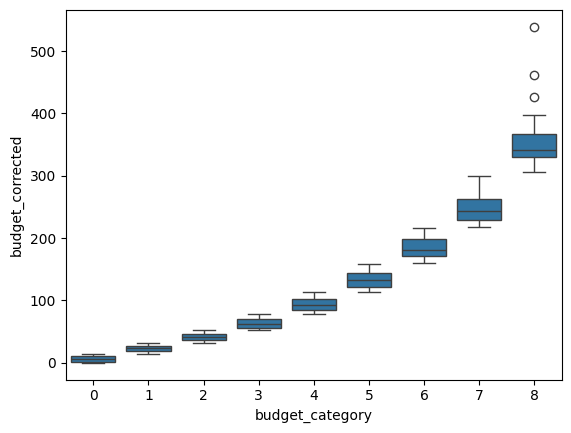

In [54]:
sns.boxplot(x='budget_category', y='budget_corrected', data=movies)
plt.show()

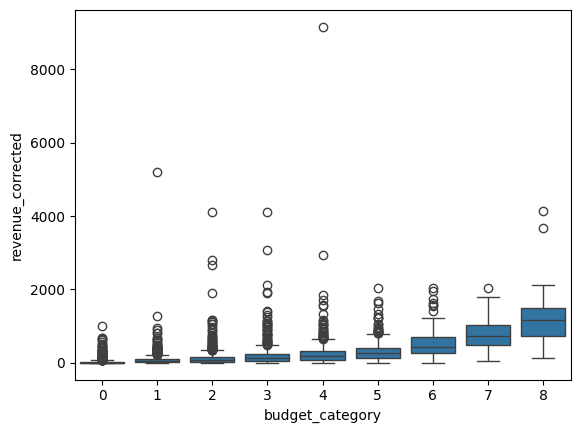

In [55]:
sns.boxplot(x='budget_category', y='revenue_corrected', data=movies)
plt.show()

In [56]:
movies['budget_category'].unique()

array([8, 7, 6, 5, 2, 1, 3, 4, 0])

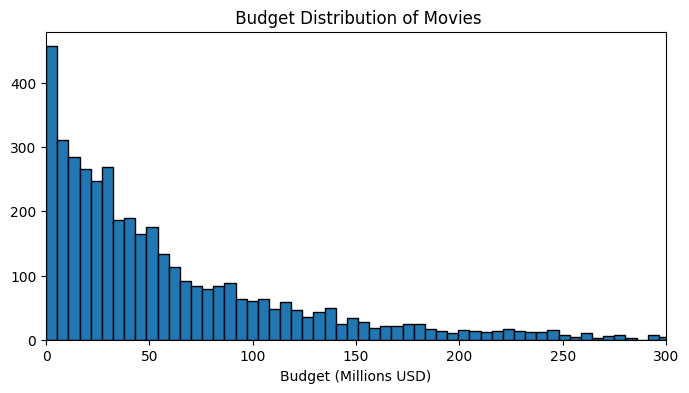

In [57]:
plt.figure(figsize=(8,4))
plt.hist(movies['budget_corrected'], bins=100, edgecolor='k')
plt.xlim(0,300)
plt.xlabel("Budget (Millions USD)")
plt.title(f" Budget Distribution of Movies")
plt.show()

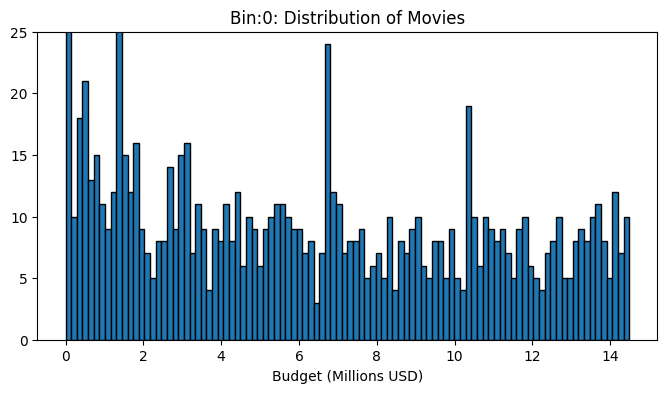

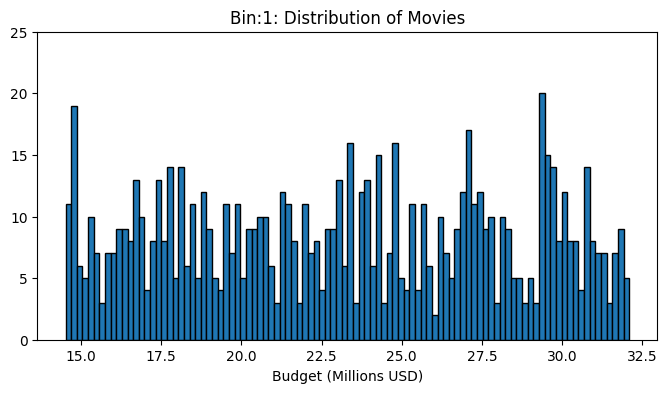

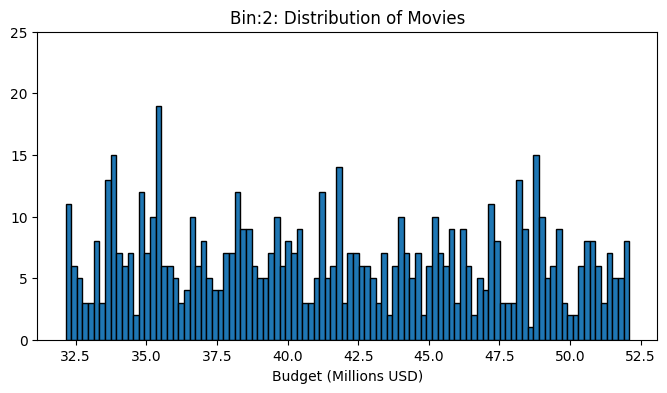

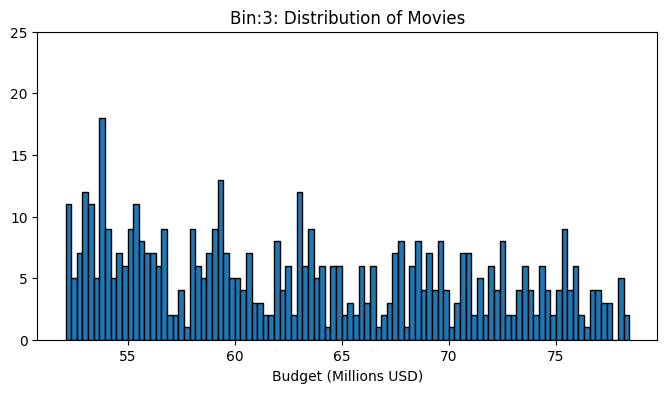

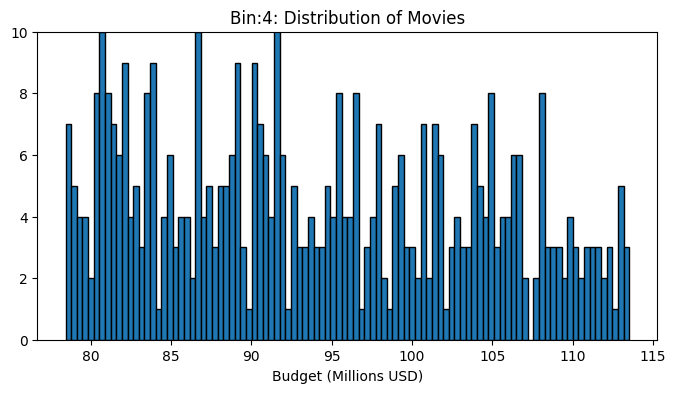

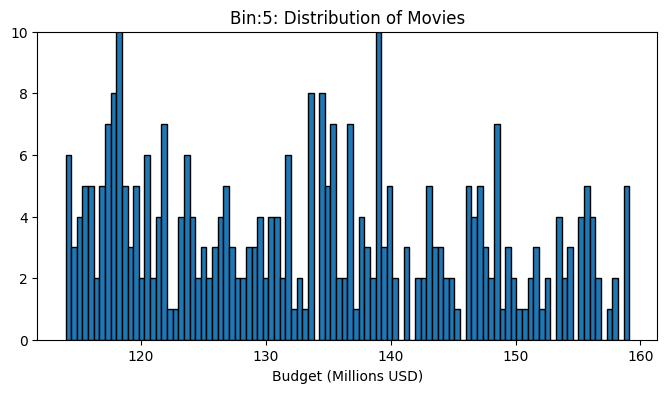

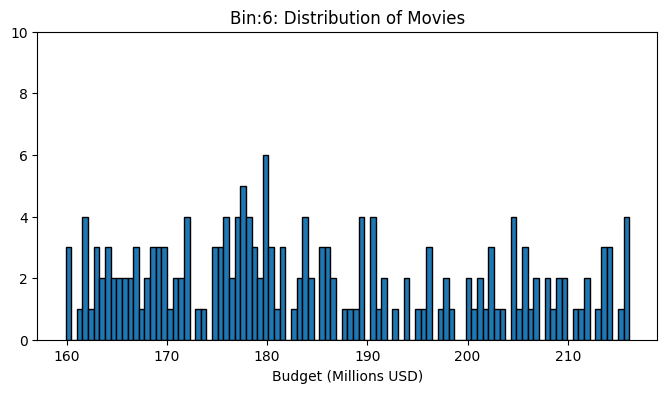

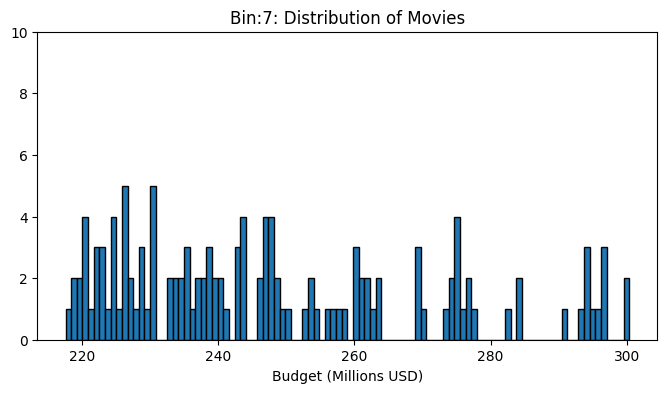

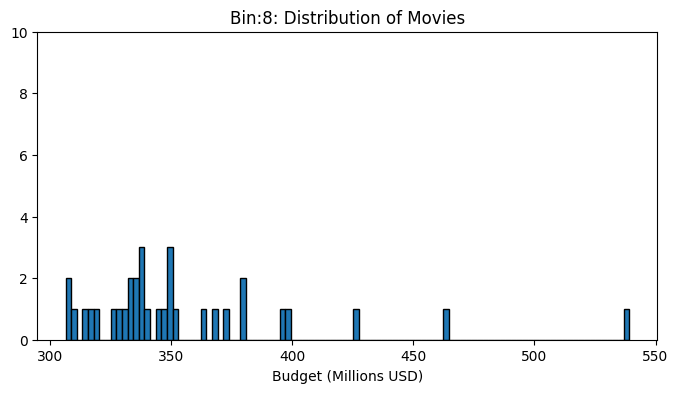

In [58]:
cat_scale = [25,25,25,25,10,10,10,10,10,10]
for cat in range(len(movies['budget_category'].unique())):
    plot_budget_category(cat, cat_scale[cat])

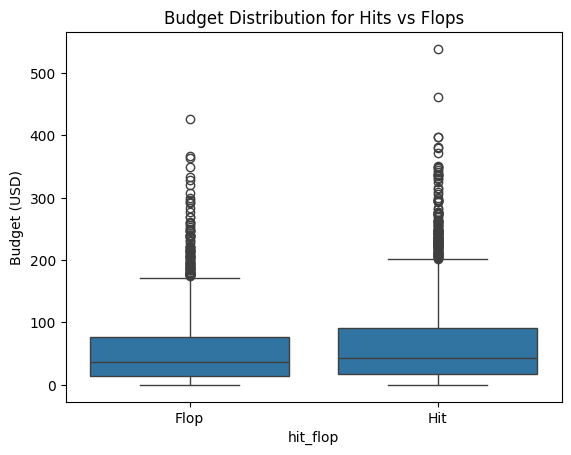

In [81]:
sns.boxplot(
    x="hit_flop",
    y="budget_corrected",
    data=movies
)

plt.xticks([0,1], ["Flop", "Hit"])
plt.ylabel("Budget (USD)")
plt.title("Budget Distribution for Hits vs Flops")
plt.show()

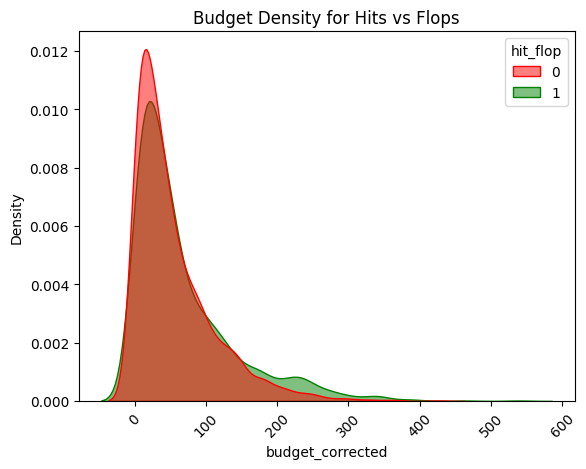

In [80]:
sns.kdeplot(
    data=movies,
    x="budget_corrected",
    hue="hit_flop",
    common_norm=False,
    fill=True,
    alpha=0.5,
    palette={0: "red", 1: "green"}
)

plt.xticks(rotation=45)
plt.title("Budget Density for Hits vs Flops")
plt.show()


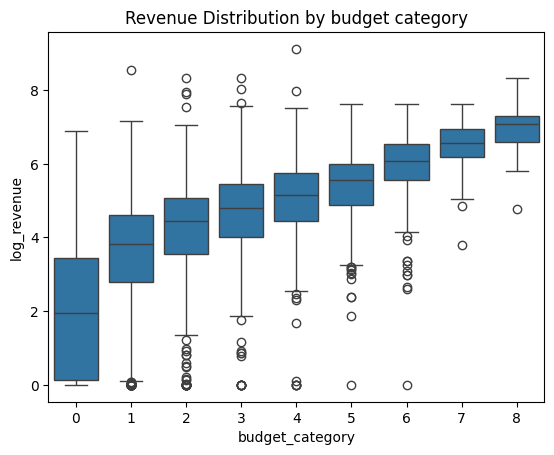

In [59]:
sns.boxplot(
    x="budget_category",
    y="log_revenue",
    data=movies
)

plt.title("Revenue Distribution by budget category")
plt.show()


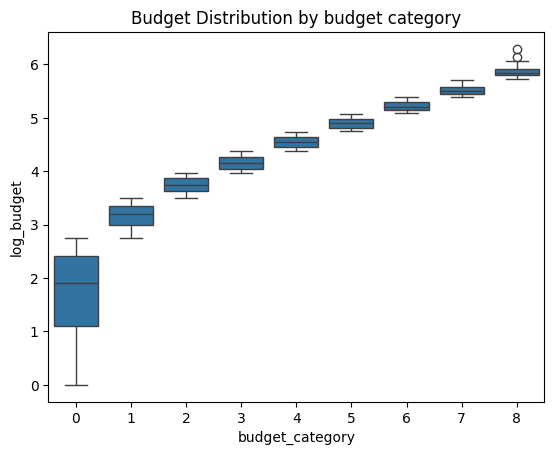

In [60]:
sns.boxplot(
    x="budget_category",
    y="log_budget",
    data=movies
)

plt.title("Budget Distribution by budget category")
plt.show()

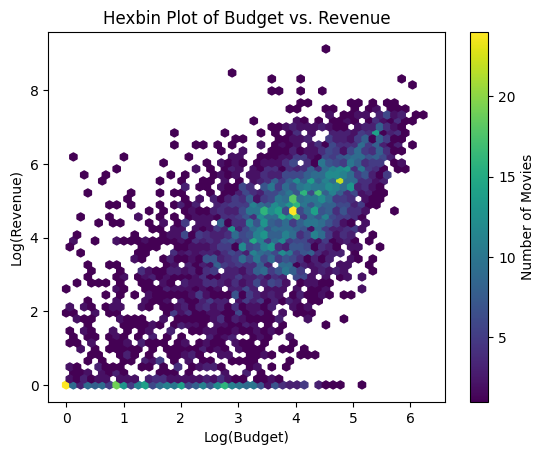

In [61]:
plt.hexbin(movies["log_budget"], movies["log_revenue"],
    gridsize=50,
    cmap='viridis',
    mincnt=1
)
plt.colorbar(label='Number of Movies')
plt.xlabel("Log(Budget)")
plt.ylabel("Log(Revenue)")
plt.title("Hexbin Plot of Budget vs. Revenue")
plt.show()


### Budget Classifier

Model to classify budget bin based on the kmean clusters.


In [62]:
# Input feature
features = ["budget_corrected"]

In [63]:
movies["budget_category"].unique()

array([8, 7, 6, 5, 2, 1, 3, 4, 0])

In [64]:
X_class = movies[features]

# Specify target as budget cluster
y_class = movies["budget_category"]

# Train/test split
X_class_train_clf, X_class_test_clf, y_class_train_clf, y_class_test_clf = train_test_split(
    X_class, y_class, test_size=0.2, random_state=42
)

# Create XGB classifier 
clf = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.1,    
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss"
)

# Train
clf.fit(X_class_train_clf, y_class_train_clf)

# Evaluate
y_class_pred_clf= clf.predict(X_class_test_clf)
print(classification_report(y_class_test_clf, y_class_pred_clf))

C:\Users\bplse\anaconda3\envs\Tf_210_Py_3819_Cuda_112_Cudn_81\lib\site-packages\xgboost\core.py:158: UserWarning: [17:59:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       1.00      0.99      1.00       182
           1       0.99      0.99      0.99       162
           2       0.98      1.00      0.99       124
           3       1.00      1.00      1.00       117
           4       1.00      1.00      1.00        92
           5       1.00      1.00      1.00        69
           6       0.98      1.00      0.99        42
           7       1.00      0.93      0.96        29
           8       0.92      1.00      0.96        11

    accuracy                           0.99       828
   macro avg       0.99      0.99      0.99       828
weighted avg       0.99      0.99      0.99       828



In [65]:
# Save model when needed
if save:
    clf.save_model()

In [66]:
class RevenueRegressor:
    def __init__(self, xgb_params=None):       
        
        self.xgb_params = xgb_params if xgb_params is not None else {            
            "n_estimators": 300,
            "max_depth": 3,
            "learning_rate": 0.1,
            "random_state": 42
        }
        self.model = XGBRegressor(**self.xgb_params)
       

    def fit(self, X, y):
        # Fit model
        self.model.fit(X, y)

    def feature_importance(self):
        importances = self.model.feature_importances_
        print("Feature importance:", importances)


    def predict(self, X_test):        
        y_pred = self.model.predict(X_test)               
        return y_pred

    def evaluate(self, X_test, y_true):       
        y_pred = self.predict(X_test)        
        mae = mean_absolute_error(y_true, y_pred)
        medae = median_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        
        print(f"Mean Absolute Error: {mae:.2f}")
        print(f"Median Absolute Error: {medae:.2f}")
        print(f"R2: {r2:.3f}")        
        return y_pred


    def hit_or_flop_df(self, budget_array, revenue_pred, revenue_true):     
        pred_status = np.where(revenue_pred > 2*budget_array, "HIT", "FLOP")
        actual_status = np.where(revenue_true > 2*budget_array, "HIT", "FLOP")
        result = np.where(pred_status == actual_status, "Same", "Mismatch")
        
        df = pd.DataFrame({
            "budget": budget_array,
            "revenue_pred": revenue_pred,
            "revenue_true": revenue_true,
            "pred_status": pred_status,
            "actual_status": actual_status,
            "comparison": result
        })
        
        return df



    def plot_residuals(self, y_true, y_pred):
       
        residuals = y_true - y_pred
        print("Mean residual:", residuals.mean())
        print("Std of residuals:", residuals.std())
        plt.figure(figsize=(8,5))
        plt.scatter(y_pred, residuals, alpha=0.5)
        plt.axhline(0, color='red', linestyle='--')
        plt.xlabel("Predicted Revenue ($)")
        plt.ylabel("Residuals ($)")
        plt.title("Residuals vs Predicted Revenue")
        plt.show()
        
    def plot_prediction(self, y_true, y_pred):       
        plt.figure(figsize=(8,5))
        plt.scatter(y_true, y_pred, alpha=0.5)
        plt.axhline(0, color='red', linestyle='--')
        plt.xlabel("Actual Revenue (million$)")
        plt.ylabel("Predicted Revenue (million$)")
        plt.title("Predicted vs Actual Revenue")
        plt.show()

        plt.figure(figsize=(8,5))
        plt.scatter(y_true, y_pred, alpha=0.5)
        plt.xlim(0,1000)
        plt.ylim(0,1000)
        plt.axhline(0, color='red', linestyle='--')
        plt.xlabel("Actual Revenue (million$)")
        plt.ylabel("Predicted Revenue (million $)")
        plt.title("Zoomed Predicted vs Actual Revenue")
        plt.show()

    def save_model(self):
        self.model.save_model("../model/revenue_prediction_xgb_model.json")



##### budget class 

  budget (million $)  -      class         

  [0, 0.01]           -     Very low      


  [0.01, 1]           -     Low           


  [1, 100]            -     Average       


  [100, 200]          -     High          


  [> 200]            -     Very high      



In [67]:
# Define features to train on
features = [
    "budget_corrected",
    'popularity',
    'runtime',
    'season_encoded',
    'budget_category',
    'main_genre_label',
    'vote_count',
]

# Define target variable
target_to_predict = 'revenue_corrected'
X = movies[features]
y = movies[target_to_predict]

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Train size:", len(X_train))
print("Test size:", len(X_test))

# Initialize regressor object 
regressor_xg = RevenueRegressor()
# Train model
regressor_xg.fit(X_train, y_train)

# Check feature importance
regressor_xg.feature_importance()        

Train size: 2895
Test size: 1242
Feature importance: [0.11142255 0.0783262  0.13987806 0.04887636 0.383527   0.02928643
 0.20868337]


#### Evaluate

Mean Absolute Error: 103.90
Median Absolute Error: 45.01
R2: 0.480


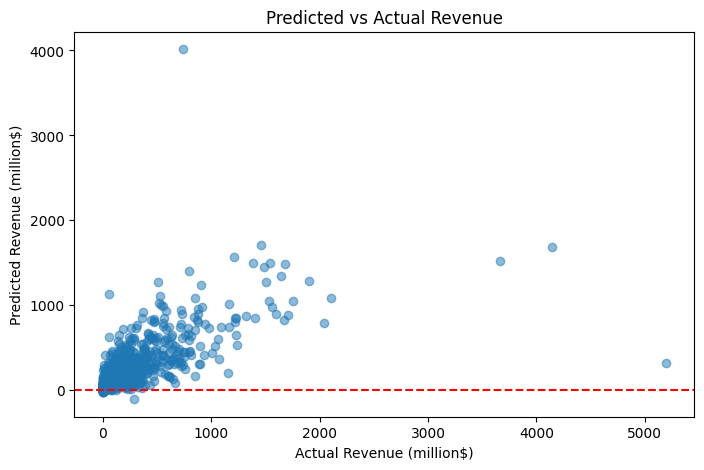

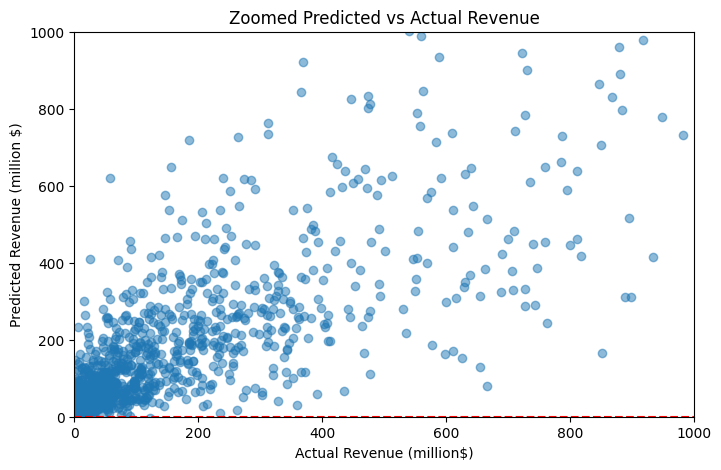

In [68]:
# Evaluate on test set
y_pred = regressor_xg.evaluate(X_test, y_test)

regressor_xg.plot_prediction(y_test, y_pred)

In [69]:
hit_flop_df = regressor_xg.hit_or_flop_df(X_test["budget_corrected"], y_pred, y_test)

In [70]:
print(hit_flop_df['comparison'].value_counts())

Same        868
Mismatch    374
Name: comparison, dtype: int64


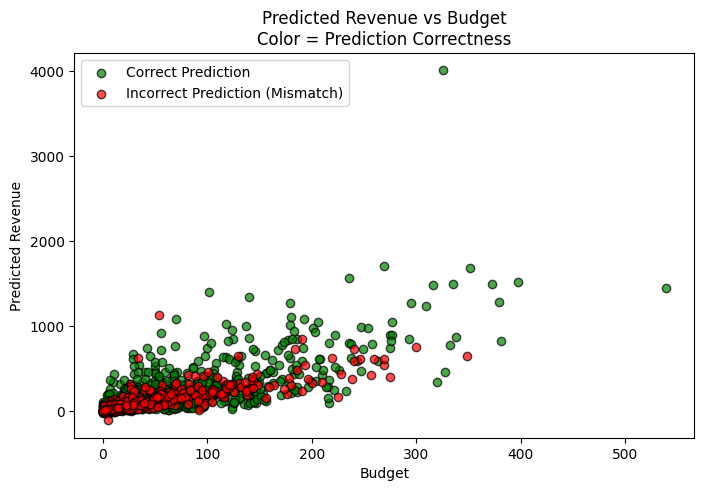

In [71]:
# Split data
same = hit_flop_df[hit_flop_df["comparison"] == "Same"]
mismatch = hit_flop_df[hit_flop_df["comparison"] == "Mismatch"]

plt.figure(figsize=(8,5))

# Plot correct predictions (green)
plt.scatter(
    same["budget"],
    same["revenue_pred"],
    color="green",
    label="Correct Prediction",
    alpha=0.7,
    edgecolor='black'
)

# Plot mismatches (red)
plt.scatter(
    mismatch["budget"],
    mismatch["revenue_pred"],
    color="red",
    label="Incorrect Prediction (Mismatch)",
    alpha=0.7,
    edgecolor='black'
)

plt.xlabel("Budget")
plt.ylabel("Predicted Revenue")
plt.title("Predicted Revenue vs Budget\nColor = Prediction Correctness")
plt.legend()
plt.show()



#### Save

In [72]:
# Save model when needed
if save:
    regressor_xg.save_model()

### Test
##### season_encoded :
Summer_Season :  month in [5, 6, 7]

Holiday_Season : month in [11, 12]

Off_Season : month in [1, 2, 9]

Regular : month in [3, 4, 8, 10]

In [73]:
# Generate a sample from test data
sample_i =10 

# budget catagory
b_value = np.array([X_test.iloc[sample_i]['budget_corrected']])
budget_class_pred= clf.predict(b_value)

movie_sample = {
    "budget_corrected": X_test.iloc[sample_i]['budget_corrected'],
    "popularity": X_test.iloc[sample_i]['popularity'],
    "runtime": X_test.iloc[sample_i]['runtime'],
    "season_encoded": X_test.iloc[sample_i]['season_encoded'],
    "budget_category": budget_class_pred[0],
    "main_genre_label": X_test.iloc[sample_i]['main_genre_label'],
    "vote_count": X_test.iloc[sample_i]['vote_count']
}
# Target variable (revenue)
movie_revenue_sample = y_test.iloc[sample_i]
print(movie_sample)
print(movie_revenue_sample)
# Get the values in the right order:
feature_order = [
    "budget_corrected",
    "popularity",
    "runtime",
    "season_encoded",
    "budget_category",
    "main_genre_label",
    "vote_count"
]

# Extract values
values = [movie_sample[feature] for feature in feature_order]

# Convert to numpy array with shape (1, n_features)
X_test_sample = np.array([values])

{'budget_corrected': 5.877402854549954, 'popularity': 4.992475, 'runtime': 120.0, 'season_encoded': 3.0, 'budget_category': 0, 'main_genre_label': 6.0, 'vote_count': 91.0}
60.86648240821714


In [74]:
pred = regressor_xg.predict(X_test_sample)  
print("Predicted revenue (million $):",pred, "\nActual revenue (million $):", movie_revenue_sample)
#regressor_xg.plot_prediction(movie_revenue_sample, pred)

Predicted revenue (million $): [37.22993] 
Actual revenue (million $): 60.86648240821714


In [75]:
#############################################################################################################################################################################